In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal, mannwhitneyu

%matplotlib inline

## Data reading and cleaning

In [180]:
df = pd.read_csv("Data/IBS-metabolome-data.txt", sep="\t", index_col="Sample")
df.drop([np.NaN, 'BLOQ Values','ALOQ Values'], inplace=True)
df.drop(['Unnamed: 33','Unnamed: 34', 'Unnamed: 35'],
        axis=1,
        inplace=True)

In [181]:
df.columns = list(df.columns[:2]) + [" ".join(col.split(" ")[:-4]) for col in list(df.columns[2:])]

In [182]:
df.replace(to_replace="NQ",
           value=np.nan,
           inplace=True)

In [183]:
df.loc["LLOQ", "Sample Weight"] = 0
df.loc["LLOQ",:] = df.loc["LLOQ",:].astype(float)
df.loc["half LLOQ",:] = df.loc["LLOQ"]/2

In [184]:
df.iloc[2:-1,:] = df.iloc[2:-1,:].fillna(df.loc["half LLOQ",:])
df.drop("half LLOQ", inplace=True)

In [185]:
df.index = [dex.replace("Ctl","control ") for dex in df.index]
df.index = [dex.replace("  "," ") for dex in df.index]

In [186]:
df["IBS"] = [np.nan] * 3 + [dex.split(" ")[1]!="control" for dex in df.index if len(dex.split(" "))>1]

In [187]:
samples_df = df.iloc[3:,2:]
samples_df.iloc[:,:-1] = samples_df.iloc[:,:-1].astype(float)

In [188]:
samples_df.head()

,myristic acid (14:0),myristoleic acid (14:1n5),pentadecanoic acid (15:0),palmitic acid (16:0),palmitoleic acid (16:1n7),margaric acid (17:0),stearic acid (18:0),oleic acid (18:1n9),vaccenic acid (18:1n7),linoleic acid (18:2n6),...,behenic acid (22:0),erucic acid (22:1n9),cis-13-16-docosadienoic acid (22:2n6),adrenic acid (22:4n6),osbond acid (22:5n6),docosapentaenoic acid (22:5n3),docosahexaenoic acid (22:6n3),lignoceric acid (24:0),nervonic acid (24:1n9),IBS
IBS control 1,10.40,0.480,10.90,204.0,3.04,4.61,284.0,138.0,8.84,94.2,...,12.80,0.395,0.206,0.48,5.34,0.800,1.6,12.50,1.590,False
IBS control 2,7.68,0.285,6.59,229.0,3.86,3.51,207.0,477.0,20.80,102.0,...,23.80,0.477,0.480,0.48,98.80,0.804,1.6,8.06,1.310,False
IBS control 3,8.98,0.480,7.81,579.0,5.88,6.23,383.0,1159.0,29.60,401.0,...,17.70,0.828,0.480,0.48,261.00,0.539,1.6,22.00,2.030,False
IBS control 4,1.15,0.480,0.49,36.0,2.43,1.45,36.0,63.2,2.70,48.6,...,1.42,0.183,0.480,0.48,0.48,0.800,1.6,1.48,0.246,False
IBS control 5,49.80,0.480,19.60,258.0,5.88,5.11,455.0,176.0,5.37,89.4,...,17.40,1.850,0.480,0.48,7.62,0.485,1.6,8.68,1.280,False


## Setup for volcano plot

In [189]:
ibs = samples_df[samples_df["IBS"]]
controls = samples_df[samples_df["IBS"]==False]

for col in samples_df.columns[:-1]:
    res = mannwhitneyu(ibs[col],
                       controls[col])
    samples_df.loc["pval",col] = res.pvalue
    samples_df.loc["-log10 pval", col] = -1 * np.log10(res.pvalue)
    
    samples_df.loc["fold change", col] = np.mean(ibs[col])/np.mean(controls[col])
    samples_df.loc["log2 fold change", col] = np.log2( np.mean(ibs[col]) / np.mean(controls[col]) )

In [190]:
plot_df = samples_df.T

In [192]:
plot_df.head()

,IBS control 1,IBS control 2,IBS control 3,IBS control 4,IBS control 5,IBS control 6,IBS control 7,IBS control 8,IBS control 9,IBS control 10,...,IBS N17,IBS N18,IBS N19,IBS N20,IBS N121,IBS N22,pval,-log10 pval,fold change,log2 fold change
myristic acid (14:0),10.4,7.68,8.98,1.15,49.8,1.76,8.08,11.5,4.66,5.28,...,76.7,8.78,14.9,112,7.37,14.2,0.0848529,1.07133,1.58644,0.66579
myristoleic acid (14:1n5),0.48,0.285,0.48,0.48,0.48,0.48,0.174,0.734,0.48,0.48,...,0.716,0.48,0.167,0.453,0.48,0.48,0.293652,0.532167,0.955867,-0.0651185
pentadecanoic acid (15:0),10.9,6.59,7.81,0.49,19.6,0.911,13.9,3.56,3.47,13,...,72.7,4.34,24.4,4.61,4.41,14.3,0.0996756,1.00141,1.64382,0.717052
palmitic acid (16:0),204,229,579,36,258,96.3,489,124,114,197,...,1377,181,474,432,392,775,0.0206515,1.68505,1.7853,0.836163
palmitoleic acid (16:1n7),3.04,3.86,5.88,2.43,5.88,14.2,2.74,3.51,2.42,2.71,...,5.29,2.57,3.09,7.43,2.95,4.89,0.454023,0.342922,1.53783,0.6209


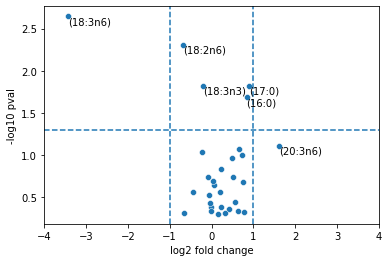

In [241]:
ax = sns.scatterplot(x="log2 fold change",
                     y="-log10 pval",
                     data=plot_df)

for name in plot_df.index:
    if plot_df.loc[name, "-log10 pval"] > -np.log10(0.05) or np.abs(plot_df.loc[name, "log2 fold change"]) > 1:
        ax.text(plot_df.loc[name, "log2 fold change"], 
                plot_df.loc[name, "-log10 pval"], 
                name.split(" ")[-1],
                horizontalalignment='left', 
                verticalalignment='top',
                size='medium',
                rotation=0)
        
ax.axhline(-np.log10(0.05), ls="--")
ax.axvline(np.log2(2), ls="--")
ax.axvline(-np.log2(2), ls="--")

ax.set_xlim(-4,4)

plt.show()

In [243]:
plot_df[(plot_df.loc[:,"-log10 pval"] > -np.log10(0.05)) | (np.abs(plot_df.loc[:,"log2 fold change"]) > 1)][["pval","fold change"]]

,pval,fold change
palmitic acid (16:0),0.0206515,1.7853
margaric acid (17:0),0.0150487,1.85532
linoleic acid (18:2n6),0.00494763,0.62784
gamma-linolenic acid (18:3n6),0.00226264,0.0923045
alpha-linolenic acid (18:3n3),0.0150433,0.870283
dihomo-gamma-linolenic acid (20:3n6),0.0771399,3.06494
